In [1]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train_path = '/content/drive/MyDrive/liar/train.tsv'
valid_path = '/content/drive/MyDrive/liar/valid.tsv'
test_path = '/content/drive/MyDrive/liar/test.tsv'

train_df = pd.read_csv(train_path,delimiter='\t',header=None, names = ['id',	'label'	,'statement',	'subject',	'speaker', 	'job', 	'state',	'party',	'barely_true_c',	'false_c',	'half_true_c',	'mostly_true_c',	'pants_on_fire_c',	'venue'])
val_df = pd.read_csv(valid_path,delimiter='\t',header=None, names = ['id',	'label'	,'statement',	'subject',	'speaker', 	'job', 	'state',	'party',	'barely_true_c',	'false_c',	'half_true_c',	'mostly_true_c',	'pants_on_fire_c',	'venue'])
test_df = pd.read_csv(test_path,delimiter='\t',header=None, names = ['id',	'label'	,'statement',	'subject',	'speaker', 	'job', 	'state',	'party',	'barely_true_c',	'false_c',	'half_true_c',	'mostly_true_c',	'pants_on_fire_c',	'venue'])
train_df.head(5)


Mounted at /content/drive


,id,label,statement,subject,speaker,job,state,party,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c,venue
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


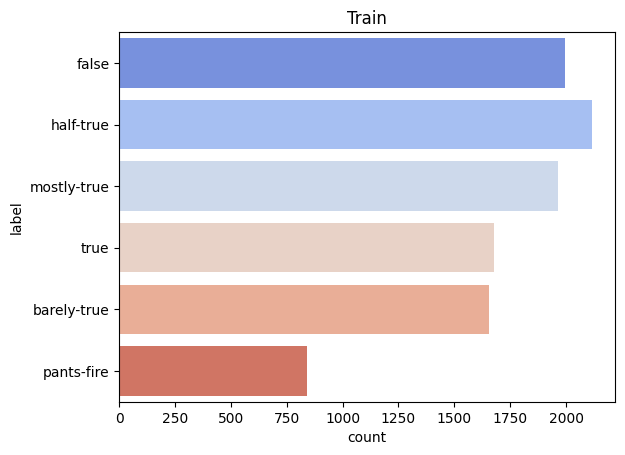

In [2]:
sns.countplot(y="label", palette="coolwarm", data=train_df).set_title('Train')
plt.show()

In [3]:
print(train_df.shape)
train_df.isna().sum()

(10240, 14)


id                    0
label                 0
statement             0
subject               2
speaker               2
job                2897
state              2208
party                 2
barely_true_c         2
false_c               2
half_true_c           2
mostly_true_c         2
pants_on_fire_c       2
venue               102
dtype: int64

In [4]:
print(val_df.shape)
val_df.isna().sum()

(1284, 14)


id                   0
label                0
statement            0
subject              0
speaker              0
job                345
state              279
party                0
barely_true_c        0
false_c              0
half_true_c          0
mostly_true_c        0
pants_on_fire_c      0
venue               12
dtype: int64

In [5]:
print(test_df.shape)
test_df.isna().sum()

(1267, 14)


id                   0
label                0
statement            0
subject              0
speaker              0
job                325
state              262
party                0
barely_true_c        0
false_c              0
half_true_c          0
mostly_true_c        0
pants_on_fire_c      0
venue               17
dtype: int64

In [6]:
from sklearn.utils import shuffle

train_df = train_df[['statement','label']]
val_df = val_df[['statement','label']]
test_df = test_df[['statement','label']]
# Shuffle
train_df = shuffle(train_df).reset_index(drop=True)
val_df = shuffle(val_df).reset_index(drop=True)
test_df = shuffle(test_df).reset_index(drop=True)

def convert_to_int(value):
    if value in [ 'half-true', 'mostly-true', 'true']:
        return 1
    elif value in ['barely-true','false', 'pants-fire']:
        return 0
    else:
        return value



train_df['label']=train_df['label'].apply(convert_to_int)
val_df['label']=val_df['label'].apply(convert_to_int)
test_df['label']=test_df['label'].apply(convert_to_int)

train_df.drop_duplicates(subset=['statement'],keep='first',inplace=True)
val_df.drop_duplicates(subset=['statement'],keep='first',inplace=True)
test_df.drop_duplicates(subset=['statement'],keep='first',inplace=True)

# df = pd.concat([train_df, valid_df, test_df]).reset_index(drop=True)

In [7]:
train_df.to_csv('train.tsv', sep='\t', index=False)
val_df.to_csv('val.tsv', sep='\t', index=False)
test_df.to_csv('test.tsv', sep='\t', index=False)

In [8]:
!pip install transformers
import torch
from transformers import BertTokenizer
PRETRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 101.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 27.1 MB/s eta 0:00:00


In [9]:
from torch.utils.data import Dataset

class FakeNewsDataset(Dataset):
    def __init__(self, mode, tokenizer):
        assert mode in ['train', 'val', 'test']
        self.mode = mode
        self.df = pd.read_csv(mode + '.tsv', sep='\t').fillna("")
        self.len = len(self.df)
        self.tokenizer = tokenizer  # BERT tokenizer

    def __getitem__(self, idx):
        if self.mode == 'test':
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)
        else:
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)

        word_pieces = ['[CLS]']
        statement = self.tokenizer.tokenize(statement)
        word_pieces += statement + ['[SEP]']
        len_st = len(word_pieces)

        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)

        segments_tensor = torch.tensor([0] * len_st, dtype=torch.long)
        
        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len
    
    
# Initialize Datasets for Transformation
trainset = FakeNewsDataset('train', tokenizer=tokenizer)
valset = FakeNewsDataset('val', tokenizer=tokenizer)
testset = FakeNewsDataset('test', tokenizer=tokenizer)

print('trainset size:' ,trainset.__len__())
print('valset size:',valset.__len__())
print('testset size: ',testset.__len__())

trainset size: 10223
valset size: 1284
testset size:  1267


In [10]:
sample_idx = 0

statement,label = trainset.df.iloc[sample_idx].values

tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = " ".join(tokens)

print(f"""
original_statement: 
{statement}

tokens: 
{tokens}

label: {label}

--------------------

tokens_tensor: 
{tokens_tensor}

segments_tensor: 
{segments_tensor}

label_tensor: 
{label_tensor}

""")


original_statement: 
98 percent of American families make under $250,000 a year.

tokens: 
['[CLS]', '98', 'percent', 'of', 'american', 'families', 'make', 'under', '$', '250', ',', '000', 'a', 'year', '.', '[SEP]']

label: 1

--------------------

tokens_tensor: 
tensor([ 101, 5818, 3867, 1997, 2137, 2945, 2191, 2104, 1002, 5539, 1010, 2199,
        1037, 2095, 1012,  102])

segments_tensor: 
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

label_tensor: 
1




In [11]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]

    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    # Zero Padding
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)

    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids


BATCH_SIZE = 16
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
testloader = DataLoader(testset, batch_size=BATCH_SIZE,collate_fn=create_mini_batch)

In [12]:
data = next(iter(trainloader))

tokens_tensors, segments_tensors, masks_tensors, label_ids = data

In [13]:
from transformers import BertForSequenceClassification
from IPython.display import display, clear_output

PRETRAINED_MODEL_NAME = "bert-base-uncased"
NUM_LABELS = 2

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

clear_output()

In [14]:
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
NUM_EPOCHS = 3
start_time = time.time()
for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    train_acc = 0.0

    loop = tqdm(trainloader)
    for batch_idx, data in enumerate(loop):
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]
        max_seq_len = 512
        tokens_tensors = tokens_tensors[:, :max_seq_len]
        segments_tensors = segments_tensors[:, :max_seq_len]
        masks_tensors = masks_tensors[:, :max_seq_len]
        optimizer.zero_grad()
        
        outputs = model(input_ids=tokens_tensors,token_type_ids=segments_tensors, attention_mask=masks_tensors, labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()

        logits = outputs[1]
        _, pred = torch.max(logits.data, 1)
        train_acc = accuracy_score(pred.cpu().tolist() , labels.cpu().tolist())

        train_loss += loss.item()

        loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        loop.set_postfix(acc = train_acc, loss = train_loss)

end_time = time.time()
training_time = end_time - start_time

device: cuda:0


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

In [15]:
torch.save(model, './best_model.pth')

BERT Model Accuracy :  0.6314127861089187
Precision :  0.6565272496831432
Recall :  0.7254901960784313
F1 :  0.6892880904856953
G-mean: 0.6082439004912766
Training time:  330.45526576042175
Inference time:  4.529524803161621
              precision    recall  f1-score   support

           0       0.59      0.51      0.55       553
           1       0.66      0.73      0.69       714

    accuracy                           0.63      1267
   macro avg       0.62      0.62      0.62      1267
weighted avg       0.63      0.63      0.63      1267



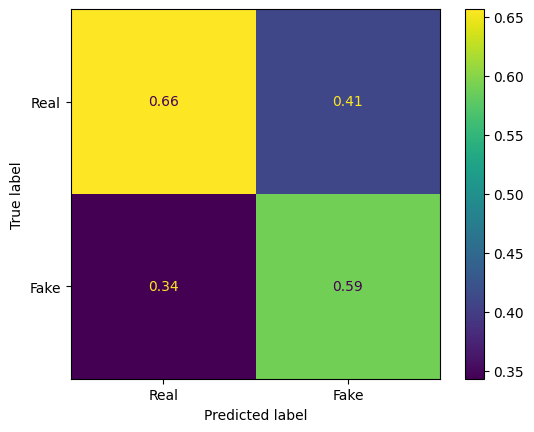

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.metrics import geometric_mean_score
true=[]
predictions=[]
start_time = time.time()
with torch.no_grad():
    model.eval()
    for data in testloader:
        if next(model.parameters()).is_cuda:
            data = [t.to(device) for t in data if t is not None]
            
        tokens_tensors, segments_tensors, masks_tensors = data[:3]
        max_seq_len = 512
        tokens_tensors = tokens_tensors[:, :max_seq_len]
        segments_tensors = segments_tensors[:, :max_seq_len]
        masks_tensors = masks_tensors[:, :max_seq_len]
        test_outputs = model(input_ids=tokens_tensors, 
                    token_type_ids=segments_tensors, 
                    attention_mask=masks_tensors)

        logits = test_outputs[0]
        _, pred = torch.max(logits.data, 1)

        labels = data[3]
        true.extend(labels.cpu().tolist())
        predictions.extend(pred.cpu().tolist())

end_time = time.time()
inference_time = end_time - start_time
cm = confusion_matrix(true, predictions, labels=[1, 0], normalize='pred')

accuracy = accuracy_score(true, predictions)

g_mean = geometric_mean_score(true, predictions)
print("BERT Model Accuracy : ", accuracy)
print("Precision : ", precision_score(true, predictions))
print("Recall : ", recall_score(true, predictions))
print("F1 : ", f1_score(true, predictions))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(true, predictions))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real','Fake'])
disp.plot()